In [52]:
from omegaconf import OmegaConf
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score

from tqdm import tqdm
import matplotlib.pyplot as plt

In [53]:
DATASET_CONFIG_PATH = "../configs/data/hemit.yaml"

cfg = OmegaConf.load(DATASET_CONFIG_PATH)

In [54]:
slide_dataframe = pd.read_csv(cfg.data.slide_dataframe_path)
val_dataframe = pd.read_csv(cfg.data.val_dataframe_path).drop(columns=["nuclei_csv_path"])
test_dataframe = pd.read_csv(cfg.data.test_dataframe_path).drop(columns=["nuclei_csv_path"])

val_dataframe = val_dataframe.merge(slide_dataframe, on="in_slide_name")
test_dataframe = test_dataframe.merge(slide_dataframe, on="in_slide_name")

In [ ]:
def get_random_f1(tile_dataframe):
    cell_dataframe = get_cell_dataframe(tile_dataframe)
    results_random = []
    for marker_col in tqdm(["Pan-CK_pos", "CD3_pos"]):
        target_marker = cell_dataframe[marker_col].values
        marker_prob = cell_dataframe[marker_col].mean()
        f1_scores = []
        for _  in range(100):
            random_pred = np.random.uniform(size=len(target_marker)) < marker_prob
            f1_scores.append(f1_score(y_true=target_marker, y_pred=random_pred))
        f1_scores = np.asarray(f1_scores)
        results_random.append([marker_col, f1_scores.mean(), f1_scores.std()])

    results_random_df = pd.DataFrame(results_random, columns=["Marker name", "F1 mean", "F1 std"])
    return results_random_df


def get_cell_dataframe(tile_dataframe):
    no_file = 0
    cell_dataframe = []
    for nuclei_csv_path in tqdm(tile_dataframe["nuclei_csv_path"].tolist()):
            try:
                nuclei_df = pd.read_csv(nuclei_csv_path, usecols=['Pan-CK_pos', 'CD3_pos'])
                cell_dataframe.append(nuclei_df)
            except FileNotFoundError:
                no_file += 1 # no file when tile with no cells
                continue
    cell_dataframe = pd.concat(cell_dataframe)
    return cell_dataframe

In [59]:
results_df_random_val = get_random_f1(val_dataframe)
results_df_random_test = get_random_f1(test_dataframe)

100%|██████████| 2/2 [00:10<00:00,  5.36s/it]


In [91]:
f1_random = np.round((results_df_random_val["F1 mean"].mean() + results_df_random_test["F1 mean"].mean()) / 2, 3)

print(f"F1 random model averaged on val and test and both markers: {f1_random}")

F1 random model averaged on val and test and both markers: 0.333


In [ ]:
result_df_miphei = pd.read_csv("/root/workdir/checkpoints_paper/vitmatte_hotpimus_lora/hemit_results_logreg.csv")
result_df_hemit = pd.read_csv("/root/workdir/checkpoints_paper/hemit_v1/hemit_results_logreg.csv")


result_df_miphei_val = result_df_miphei[result_df_miphei["Set"] == "Val"]
result_df_miphei_test = result_df_miphei[result_df_miphei["Set"] == "Test"]

result_df_hemit_val = result_df_hemit[result_df_hemit["Set"] == "Val"]
result_df_hemit_test = result_df_hemit[result_df_hemit["Set"] == "Test"]

In [ ]:
def generate_hemit_baplot(marker_name, result_df_miphei, result_df_hemit, results_df_random, split="val"):

    df = pd.DataFrame(columns=["Model Name", "Cell AUC", "Cell F1"])
    df["Model Name"] = ["VitMatte (Orion)", "HEMIT", "Random"]
    df["Cell AUC"] = [result_df_miphei[result_df_miphei["Marker"] == marker_name]["ROC AUC"].item(),
                    result_df_hemit[result_df_hemit["Marker"] == marker_name]["ROC AUC"].item(),
                    None,
                    ]
    df["Cell F1"] = [result_df_miphei[result_df_miphei["Marker"] == marker_name]["F1 Score"].item(),
                    result_df_hemit[result_df_hemit["Marker"] == marker_name]["F1 Score"].item(),
                    results_df_random[results_df_random["Marker name"] == marker_name]["F1 mean"].item(),
                    ]
    df.head()


    # Melt the dataframe to long format for Seaborn
    df_melted = df.melt(id_vars=['Model Name'], var_name='Metric', value_name='Performance')

    # Use a predefined Seaborn color palette
    sns.set_palette("Set1")

    # Set larger font sizes globally
    sns.set_context("talk", font_scale=1.3)  # Controls overall font size

    # Plot
    plt.figure(figsize=(7,4))  # Increase figure size

    # Custom barplot with bar width and edge rounding
    ax = sns.barplot(
        data=df_melted, x='Metric', y='Performance', hue='Model Name', 
        edgecolor="black", linewidth=1.5, width=1.  # Controls bar shape
    )

    for p in ax.patches:
        if p.get_height() > 0:  # Avoid 0 labels
            ax.annotate(f'{p.get_height():.2f}', 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='bottom', 
                        fontsize=18, fontweight='bold', color='black')

    # Increase font sizes for labels
    plt.xlabel("")
    plt.ylabel("")
    plt.ylim(0., 1.1)
    ax.set_yticks([])
    plt.title(marker_name.replace("_pos", ""), fontsize=32, fontweight='bold')


    # Adjust legend font size
    #plt.legend(title='Model', loc='upper right', fontsize=14, title_fontsize=14)
    plt.legend().remove()

    # Save as SVG
    clean_marker_name = marker_name.replace("_pos", "")
    plt.savefig(f"hemit_{split}_{clean_marker_name}.svg", format="svg", bbox_inches="tight")

    # Show plot
    plt.show()

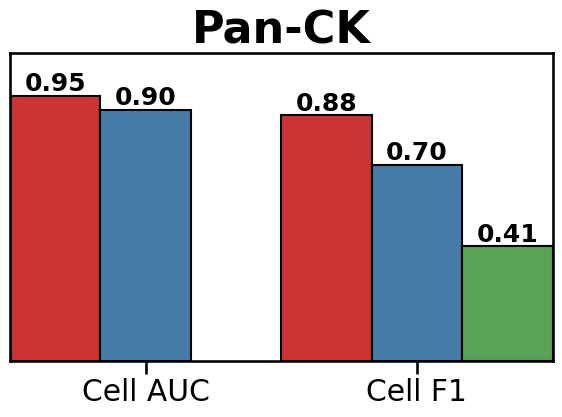

In [ ]:
generate_hemit_baplot("Pan-CK_pos", result_df_miphei_val, result_df_hemit_val, results_df_random_val, split="val")

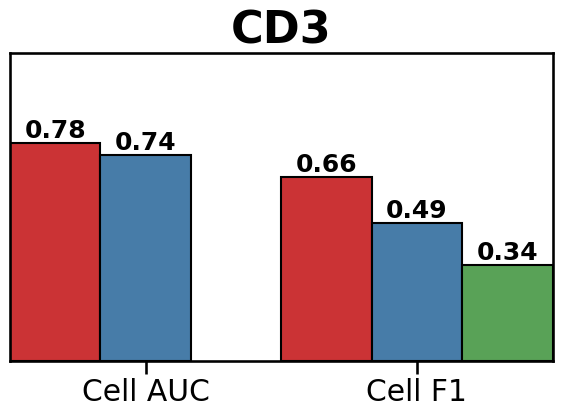

In [ ]:
generate_hemit_baplot("CD3_pos", result_df_miphei_val, result_df_hemit_val, results_df_random_val, split="val")

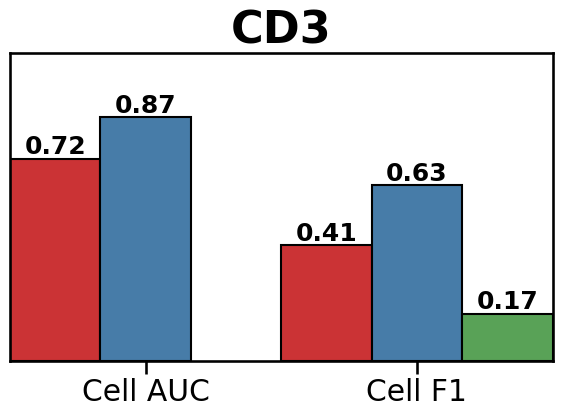

In [ ]:
generate_hemit_baplot("CD3_pos", result_df_miphei_test, result_df_hemit_test, results_df_random_test, split="test")

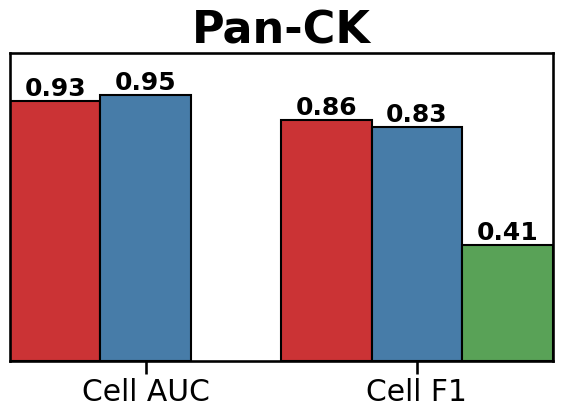

In [ ]:
generate_hemit_baplot("Pan-CK_pos", result_df_miphei_test, result_df_hemit_test, results_df_random_test, split="test")